In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

2024-04-10 10:23:32.118042: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 10:23:34.093834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_csv('/home/chudeo/project/Evidence_sentences.csv')
sentences = data['sentence'].tolist()
labels = [label.split(',') for label in data['word_labels']]

Preprocess the data:

In [3]:
# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


In [4]:
# Find the maximum sequence length
max_len = max(len(seq) for seq in sequences)

# Pad the sequences
X = pad_sequences(sequences, maxlen=max_len, padding='post')

In [5]:
from keras.utils import to_categorical


# Convert labels to numerical values
unique_labels = set([label for labels_list in labels for label in labels_list])
label_to_id = {label: i for i, label in enumerate(unique_labels)}
y = [[label_to_id[label] for label in labels_list] for labels_list in labels]
y = pad_sequences(y, maxlen=max_len, padding='post')
y = [to_categorical(seq, num_classes=len(unique_labels)) for seq in y]


Build the Bidirectional LSTM model:


In [6]:
# Build the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-04-10 10:23:36.954460: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Train the model
model.fit(X, np.array(y), epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9409 - loss: 0.1359 - val_accuracy: 0.9878 - val_loss: 0.0462
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9886 - loss: 0.0400 - val_accuracy: 0.9878 - val_loss: 0.0428
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9884 - loss: 0.0364 - val_accuracy: 0.9879 - val_loss: 0.0416
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9886 - loss: 0.0333 - val_accuracy: 0.9879 - val_loss: 0.0408
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9894 - loss: 0.0300 - val_accuracy: 0.9877 - val_loss: 0.0409
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9903 - loss: 0.0265 - val_accuracy: 0.9876 - val_loss: 0.0421
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9910 - loss: 0.0245 - val_accuracy: 0.9877 - val_loss: 0.0445
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9914 - loss: 0.0227 - v

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(X, np.array(y))
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9927 - loss: 0.0192
Loss: 0.0246, Accuracy: 0.9916


In [9]:
def predict_entities(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')
    predictions = model.predict(padded_sequence)
    predicted_labels = [[list(unique_labels)[np.argmax(label)] for label in prediction] for prediction in predictions[0]]
    return predicted_labels

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict labels for the data
predictions = model.predict(X)
predicted_labels = np.argmax(predictions, axis=-1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


In [11]:
# Convert one-hot encoded labels to single labels
true_labels = np.argmax(np.array(y), axis=-1)

In [12]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels.flatten(), predicted_labels.flatten())
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1211218    1296     671]
 [   3003    4410     264]
 [   4445     682    1449]]


In [13]:
# Generate classification report
report = classification_report(true_labels.flatten(), predicted_labels.flatten(), target_names=list(unique_labels))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           O       0.99      1.00      1.00   1213185
           I       0.69      0.57      0.63      7677
           B       0.61      0.22      0.32      6576

    accuracy                           0.99   1227438
   macro avg       0.76      0.60      0.65   1227438
weighted avg       0.99      0.99      0.99   1227438



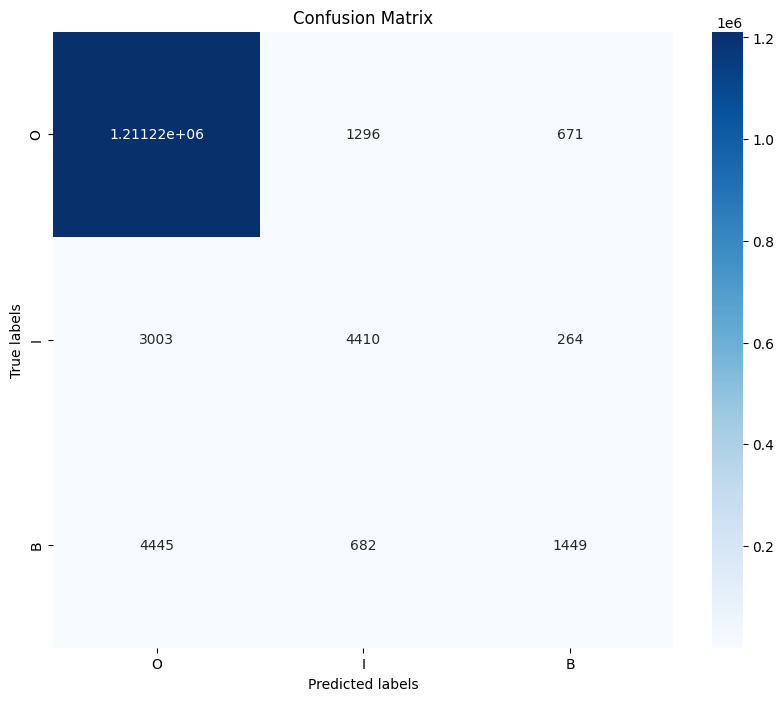

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=list(unique_labels), yticklabels=list(unique_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


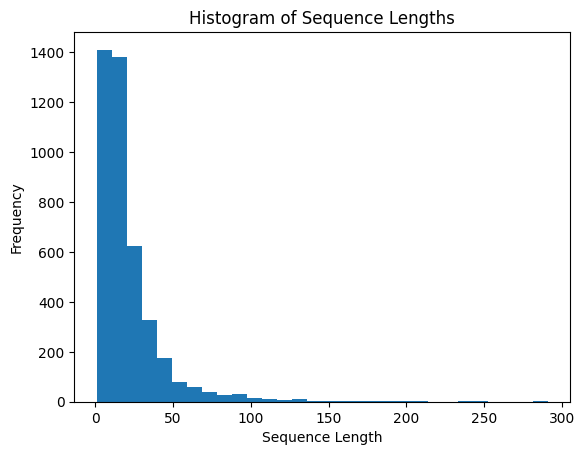

In [15]:
#Histogram of Sequence Lengths
plt.hist([len(seq) for seq in sequences], bins=30)
plt.title('Histogram of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


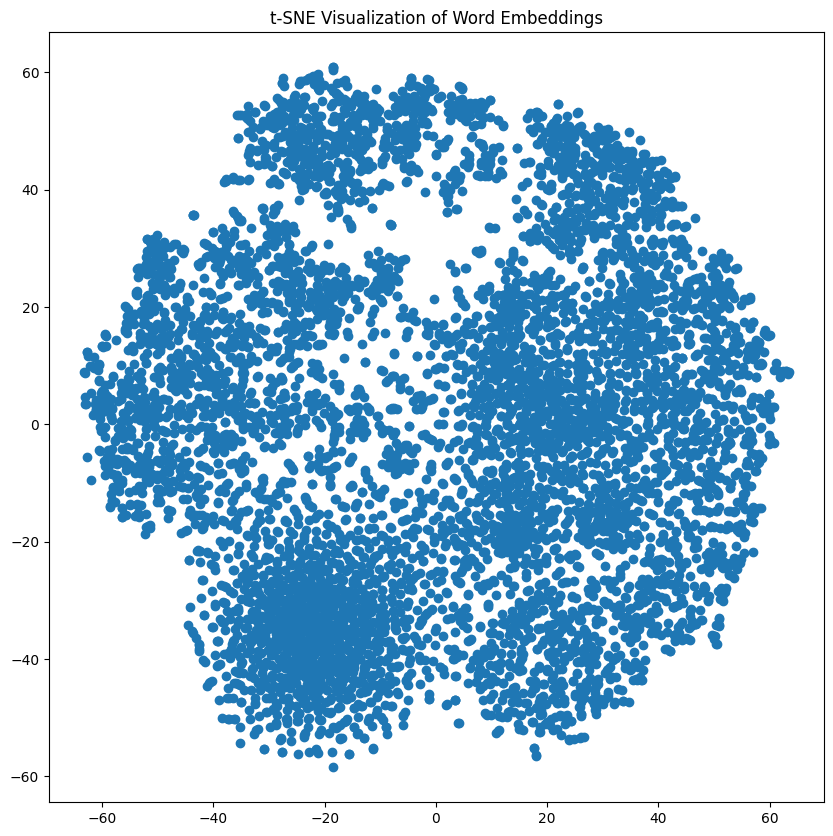

In [16]:
# If using pre-trained embeddings, you can visualize them using t-SNE or PCA
# For t-SNE
from sklearn.manifold import TSNE

# Assuming your embeddings are in model.layers[0].get_weights()[0]
embeddings = model.layers[0].get_weights()[0]

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title('t-SNE Visualization of Word Embeddings')
plt.show()


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9928 - loss: 0.0184 - val_accuracy: 0.9861 - val_loss: 0.0509
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9932 - loss: 0.0177 - val_accuracy: 0.9869 - val_loss: 0.0540
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9937 - loss: 0.0161 - val_accuracy: 0.9857 - val_loss: 0.0584
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9940 - loss: 0.0156 - val_accuracy: 0.9862 - val_loss: 0.0572
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9940 - loss: 0.0151 - val_accuracy: 0.9860 - val_loss: 0.0603
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9947 - loss: 0.0137 - val_accuracy: 0.9849 - val_loss: 0.0641
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9950 - loss: 0.0132 - val_accuracy: 0.9859 - val_loss: 0.0643
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9950 - loss: 0.0128 - 

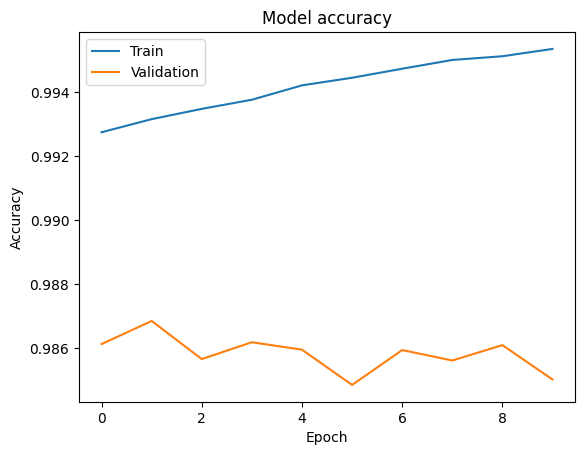

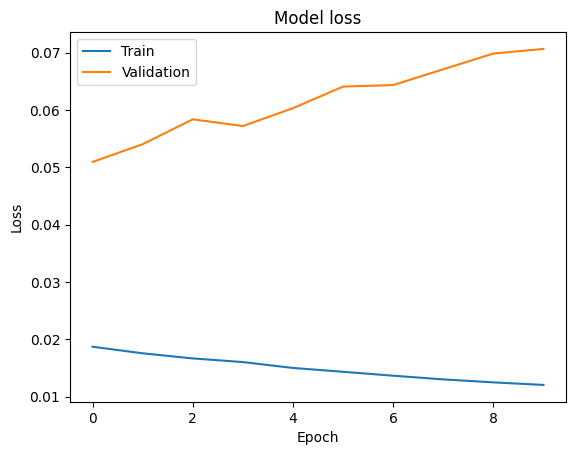

In [17]:
# Train the model
history = model.fit(X, np.array(y), epochs=10, batch_size=32, validation_split=0.2)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
